# Import Library

In [152]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,Dropout,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import TerminateOnNaN

# Load data

In [153]:
base_dir = '../data'  # Ganti dengan path folder utama Anda
train_dir = f'{base_dir}/train'        # Subfolder train
validation_dir = f'{base_dir}/validation'   # Subfolder valid
test_dir = f'{base_dir}/test'          # Subfolder test

In [154]:
# Resclae data Ke 255
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10, #10
    width_shift_range=0.03,
    height_shift_range=0.03, #0.05 
    zoom_range=[0.95,1.05],
    horizontal_flip=True,
    fill_mode='constant',
    brightness_range=[0.98, 1.02], # 85 1.05
    # channel_shift_range=0.1,
    # shear_range =0.01 #ini
    )
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [155]:
# Memuat Data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Sesuaikan dengan ukuran input MobileNet
    batch_size=32, #32
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32, # 64
    class_mode='categorical',
    shuffle = False
)


Found 1500 images belonging to 4 classes.
Found 300 images belonging to 4 classes.
Found 200 images belonging to 4 classes.


# Create MobileNet

In [156]:
# Load MobileNet dengan Transfer Learning
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = True
for layer in base_model.layers[:-40]:
    layer.trainable = False

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256,activation='relu',kernel_regularizer=l2(l2=3e-4))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(128,activation='relu',kernel_regularizer=l2(l2=3e-4))(x)
x = BatchNormalization()(x)
predictions = Dense(train_generator.num_classes, activation='softmax',kernel_regularizer=l2(l2=3e-4))(x)

model = Model(inputs=base_model.input, outputs=predictions)


In [168]:
model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 9,983,822 (38.09 MB)

 Trainable params: 3,228,804 (12.32 MB)

 Non-trainable params: 297,408 (1.13 MB)

 Optimizer params: 6,457,610 (24.63 MB)

In [158]:
# Compile Model
model.compile(optimizer=Adam(learning_rate=0.00007,decay=1e-6,epsilon=1e-07,clipnorm=0.8  # Nilai epsilon lebih kecil
), loss='categorical_crossentropy', metrics=['accuracy'],
    )

c:\Users\CUDE COMPUTER\anaconda3\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [159]:
# Callbacks
callbacks= [
ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, min_lr=1e-8), #0.00001
# EarlyStopping(monitor='val_accuracy',patience=5,restore_best_weights=True, mode='max',baseline=0.97),
ModelCheckpoint('best_model_copy.h5', monitor='val_accuracy', save_best_only=True, mode='max'),
# TerminateOnNaN()
]

In [160]:
# Train Model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=25,
    callbacks=callbacks,
    # verbose=1
)

c:\Users\CUDE COMPUTER\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4557 - loss: 1.4784

46/46 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.4591 - loss: 1.4710 - val_accuracy: 0.7639 - val_loss: 0.9116 - learning_rate: 7.0000e-05
Epoch 2/25
 1/46 ━━━━━━━━━━━━━━━━━━━━ 1:03 1s/step - accuracy: 0.8438 - loss: 0.6383

c:\Users\CUDE COMPUTER\anaconda3\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 140ms/step - accuracy: 0.8438 - loss: 0.6383 - val_accuracy: 0.7708 - val_loss: 0.9022 - learning_rate: 7.0000e-05
Epoch 3/25
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8027 - loss: 0.6483

46/46 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.8034 - loss: 0.6474 - val_accuracy: 0.8056 - val_loss: 0.7402 - learning_rate: 7.0000e-05
Epoch 4/25
46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 0.7500 - loss: 0.7218 - val_accuracy: 0.8021 - val_loss: 0.7426 - learning_rate: 7.0000e-05
Epoch 5/25
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9097 - loss: 0.4739

46/46 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.9097 - loss: 0.4739 - val_accuracy: 0.8646 - val_loss: 0.5978 - learning_rate: 7.0000e-05
Epoch 6/25
46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - accuracy: 0.9688 - loss: 0.3337 - val_accuracy: 0.8576 - val_loss: 0.6024 - learning_rate: 7.0000e-05
Epoch 7/25
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9142 - loss: 0.4260

46/46 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.9142 - loss: 0.4257 - val_accuracy: 0.8993 - val_loss: 0.4831 - learning_rate: 7.0000e-05
Epoch 8/25
46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.8750 - loss: 0.3700 - val_accuracy: 0.8958 - val_loss: 0.4907 - learning_rate: 7.0000e-05
Epoch 9/25
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9371 - loss: 0.3460

46/46 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.9370 - loss: 0.3461 - val_accuracy: 0.9306 - val_loss: 0.3921 - learning_rate: 7.0000e-05
Epoch 10/25
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.9375 - loss: 0.3511 - val_accuracy: 0.9306 - val_loss: 0.3906 - learning_rate: 7.0000e-05
Epoch 11/25
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9535 - loss: 0.3130

46/46 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.9536 - loss: 0.3128 - val_accuracy: 0.9410 - val_loss: 0.3681 - learning_rate: 7.0000e-05
Epoch 12/25
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - accuracy: 0.9062 - loss: 0.4275 - val_accuracy: 0.9375 - val_loss: 0.3588 - learning_rate: 7.0000e-05
Epoch 13/25
46/46 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.9654 - loss: 0.2767 - val_accuracy: 0.9375 - val_loss: 0.3351 - learning_rate: 7.0000e-05
Epoch 14/25
46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 1.0000 - loss: 0.2061 - val_accuracy: 0.9410 - val_loss: 0.3296 - learning_rate: 7.0000e-05
Epoch 15/25
46/46 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.9812 - loss: 0.2474 - val_accuracy: 0.9410 - val_loss: 0.3349 - learning_rate: 7.0000e-05
Epoch 16/25
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - accuracy: 0.9688 - loss: 0.2768 - val_accuracy: 0.9375 - val_loss: 0.3404 - learning_rate: 7.0000e-05
Epoch 17/25
46/46 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.9758 - loss: 

46/46 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.9754 - loss: 0.2577 - val_accuracy: 0.9514 - val_loss: 0.3181 - learning_rate: 6.3000e-06
Epoch 20/25
46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 1.0000 - loss: 0.2550 - val_accuracy: 0.9479 - val_loss: 0.3194 - learning_rate: 6.3000e-06
Epoch 21/25
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9956 - loss: 0.2141

46/46 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.9956 - loss: 0.2143 - val_accuracy: 0.9549 - val_loss: 0.3142 - learning_rate: 6.3000e-06
Epoch 22/25
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 1.0000 - loss: 0.2048 - val_accuracy: 0.9549 - val_loss: 0.3147 - learning_rate: 6.3000e-06
Epoch 23/25
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9914 - loss: 0.2277

46/46 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.9915 - loss: 0.2275 - val_accuracy: 0.9583 - val_loss: 0.3036 - learning_rate: 6.3000e-06
Epoch 24/25
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.9375 - loss: 0.2957 - val_accuracy: 0.9549 - val_loss: 0.3080 - learning_rate: 6.3000e-06
Epoch 25/25
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9899 - loss: 0.2185

46/46 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.9899 - loss: 0.2185 - val_accuracy: 0.9653 - val_loss: 0.2946 - learning_rate: 6.3000e-06


In [161]:
print("Number of classes in test_generator:", test_generator.num_classes)
print("Number of classes in model output:", model.output_shape)

Number of classes in test_generator: 4
Number of classes in model output: (None, 4)


In [162]:
# Load model terbaik
model.load_weights('best_model_copy.h5')

In [163]:
# Evaluate Model
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc:.4f}')
print(f'Test Loss: {test_loss:.4f}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 602ms/step - accuracy: 0.9610 - loss: 0.3070
Test accuracy: 0.9650
Test Loss: 0.3067


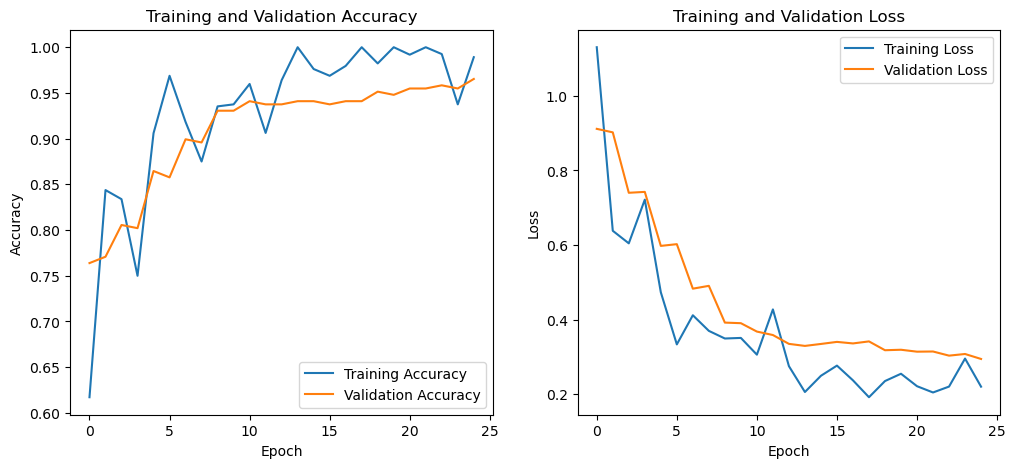

In [164]:
plt.figure(figsize=(12, 5))
# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 986ms/step
Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       0.94      1.00      0.97        50
meningioma_tumor       0.98      0.90      0.94        50
        no_tumor       1.00      0.96      0.98        50
 pituitary_tumor       0.94      1.00      0.97        50

        accuracy                           0.96       200
       macro avg       0.97      0.96      0.96       200
    weighted avg       0.97      0.96      0.96       200



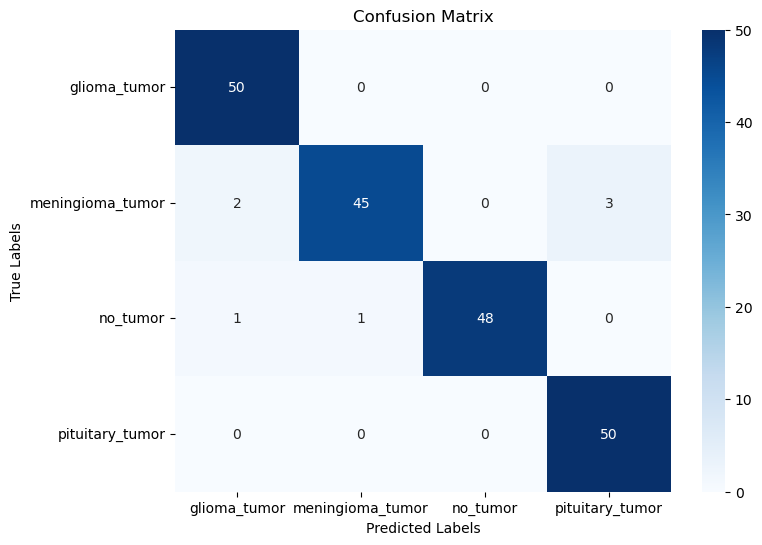

In [165]:
# 8. Prediksi pada Data Test
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)  # Konversi probabilitas ke label integer

# 9. Ambil Label Sebenarnya
y_true = test_generator.classes  # Label sebenarnya dari generator

# 10. Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=list(test_generator.class_indices.keys())))

# 11. Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=test_generator.class_indices.keys(), 
            yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Simpan Model MobileNet

In [ ]:
# Simpan Model
# model.save('mobilenetv1_copy.h5')